### GRU Model for Sri Lanka Weather Forcast

In [4]:
import os
import xarray as xr
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score

# Dataset class
class WeatherT2MDataset(Dataset):
    def __init__(self, nc_file, seq_len=24, pred_len=1, max_samples=10000):
        ds = xr.open_dataset(nc_file)
        data = ds['t2m'].values  # (time, lat, lon)
        data = np.nan_to_num(data)
        self.data = data.reshape(data.shape[0], -1)
        self.mean = np.mean(self.data)
        self.std = np.std(self.data)
        self.data = (self.data - self.mean) / self.std
        self.samples = []
        total_seq = len(self.data) - seq_len - pred_len + 1
        for i in range(min(total_seq, max_samples)):
            X = self.data[i:i+seq_len]
            y = self.data[i+seq_len:i+seq_len+pred_len]
            self.samples.append((X, y))
        print(f"Loaded {len(self.samples)} samples (each: seq {seq_len}, pred {pred_len})")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        X, y = self.samples[idx]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# GRU Model
class GRUWeather(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, pred_len=1):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size * pred_len)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out.view(x.shape[0], -1, x.shape[2])

# Evaluation metrics
def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred))
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / np.where(denom == 0, 1, denom))

def nash_sutcliffe(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

def compute_metrics(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    r2 = r2_score(y_true, y_pred)
    evs = explained_variance_score(y_true, y_pred)
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    smape_score = smape(y_true, y_pred)
    nse = nash_sutcliffe(y_true, y_pred)
    return {
        'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape, 'R2': r2,
        'EVS': evs, 'Pearson_r': corr, 'sMAPE': smape_score, 'NSE': nse
    }

### Training function with accuracy tracking

In [5]:
# Training function with accuracy tracking
def train_model(model, train_loader, val_loader, device, epochs=10, lr=1e-3):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    for epoch in range(epochs):
        model.train()
        tr_loss = 0
        tr_true, tr_pred = [], []
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(X)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            tr_loss += loss.item()
            tr_true.append(y.cpu().numpy())
            tr_pred.append(pred.cpu().detach().numpy())
        train_losses.append(tr_loss / len(train_loader))
        # Train accuracy (R2)
        tr_true = np.concatenate(tr_true, axis=0)
        tr_pred = np.concatenate(tr_pred, axis=0)
        train_r2 = r2_score(tr_true.flatten(), tr_pred.flatten())
        train_accuracies.append(train_r2)
        # Validation
        model.eval()
        val_loss = 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                pred = model(X)
                val_loss += criterion(pred, y).item()
                val_true.append(y.cpu().numpy())
                val_pred.append(pred.cpu().numpy())
        val_losses.append(val_loss / len(val_loader))
        val_true = np.concatenate(val_true, axis=0)
        val_pred = np.concatenate(val_pred, axis=0)
        val_r2 = r2_score(val_true.flatten(), val_pred.flatten())
        val_accuracies.append(val_r2)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Train R²: {train_r2:.4f} | Val R²: {val_r2:.4f}")
    return train_losses, val_losses, train_accuracies, val_accuracies

In [6]:
# Main
def main():
    nc_file = "SriLanka.nc"  # Path to your NetCDF file
    seq_len = 24
    pred_len = 1
    batch_size = 32
    epochs = 35

    dataset = WeatherT2MDataset(nc_file, seq_len, pred_len)
    total_samples = len(dataset)
    train_size = int(0.8 * total_samples)
    val_size = total_samples - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    input_size = dataset.data.shape[1]
    model = GRUWeather(input_size)
    device = torch.device('cpu')

    print(f"Total samples: {total_samples}. Train: {train_size}, Val: {val_size}")

    train_losses, val_losses, train_acc, val_acc = train_model(
        model, train_loader, val_loader, device, epochs=epochs
    )

    # Plot Losses and Accuracy
    plt.figure(figsize=(12, 6))

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.title("Training and Validation Loss")

    # Plot Training and Validation Accuracy (R²)
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train R²')
    plt.plot(val_acc, label='Val R²')
    plt.xlabel("Epoch")
    plt.ylabel("R² Score (Accuracy)")
    plt.legend()
    plt.title("Training and Validation R² (Accuracy)")

    plt.tight_layout()
    plt.show()

    # ---- Final Evaluation on Validation Set ----
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X, y in val_loader:
            X = X.to(device)
            outputs = model(X)
            y_true.append(y.numpy())
            y_pred.append(outputs.numpy())
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)
    metrics = compute_metrics(y_true, y_pred)
    print("\n--- Evaluation Metrics on Validation Set ---")
    for k, v in metrics.items():
        if 'MAPE' in k or 'sMAPE' in k:
            print(f"{k}: {v:.2f}%")
        else:
            print(f"{k}: {v:.4f}")

Loaded 10000 samples (each: seq 24, pred 1)
Total samples: 10000. Train: 8000, Val: 2000
Epoch 1/35 - Train Loss: 0.1694 | Val Loss: 0.0670 | Train R²: 0.8318 | Val R²: 0.9336
Epoch 2/35 - Train Loss: 0.0585 | Val Loss: 0.0525 | Train R²: 0.9419 | Val R²: 0.9480
Epoch 3/35 - Train Loss: 0.0462 | Val Loss: 0.0443 | Train R²: 0.9541 | Val R²: 0.9562
Epoch 4/35 - Train Loss: 0.0379 | Val Loss: 0.0358 | Train R²: 0.9624 | Val R²: 0.9646
Epoch 5/35 - Train Loss: 0.0332 | Val Loss: 0.0329 | Train R²: 0.9670 | Val R²: 0.9674
Epoch 6/35 - Train Loss: 0.0301 | Val Loss: 0.0292 | Train R²: 0.9701 | Val R²: 0.9711
Epoch 7/35 - Train Loss: 0.0278 | Val Loss: 0.0286 | Train R²: 0.9724 | Val R²: 0.9716
Epoch 8/35 - Train Loss: 0.0263 | Val Loss: 0.0262 | Train R²: 0.9739 | Val R²: 0.9740
Epoch 9/35 - Train Loss: 0.0252 | Val Loss: 0.0260 | Train R²: 0.9750 | Val R²: 0.9742
Epoch 10/35 - Train Loss: 0.0236 | Val Loss: 0.0247 | Train R²: 0.9766 | Val R²: 0.9756
Epoch 11/35 - Train Loss: 0.0234 | Val L

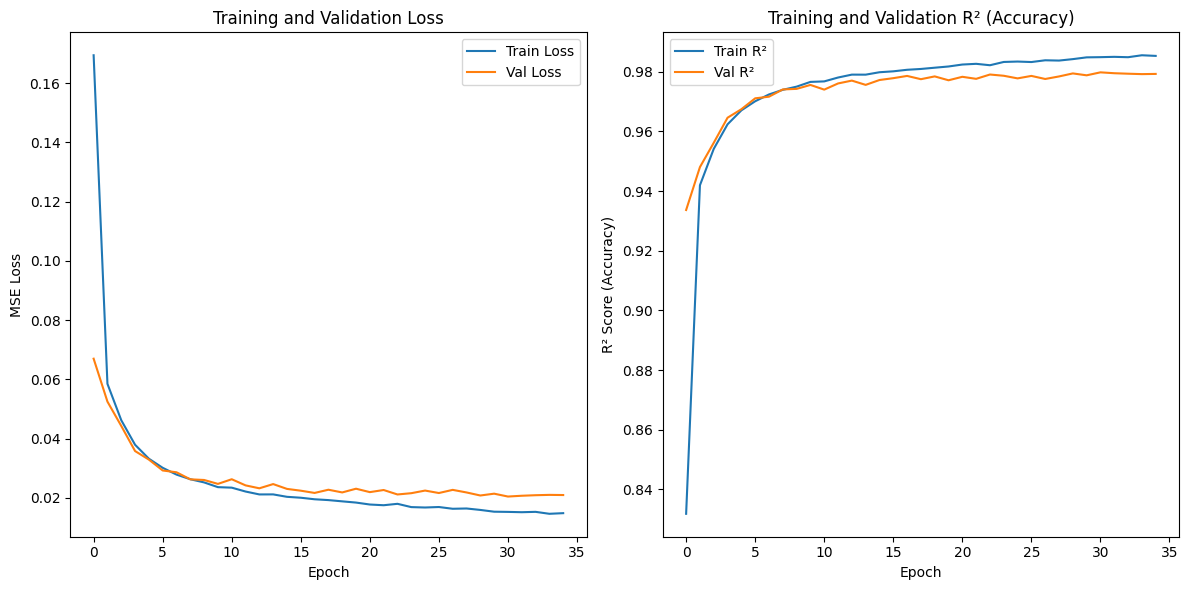


--- Evaluation Metrics on Validation Set ---
MAE: 0.1005
MSE: 0.0210
RMSE: 0.1449
MAPE: 131.11%
R2: 0.9792
EVS: 0.9794
Pearson_r: 0.9897
sMAPE: 31.41%
NSE: 0.9792


In [7]:
if __name__ == '__main__':
    main()